### Notebook for experimenting/debugging data reduction related stuff and doing initial data analysis

In [1]:
from data_reduction import DataSheet, xlsx_temp_series, xlsx_modulation, df_label_names
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.debugger import Tracer

In [2]:
# Define constants
NUM_SHEETS_MOD = 32
NUM_SHEETS_TEMP = 8

In [3]:
# Create a list of DataSheet objects for the flux bias current/modulation Excel sheet
mod_DataSheets = []
for j in range(NUM_SHEETS_MOD):
    mod_DataSheets.append(DataSheet(xlsx_modulation, 'modulation', sheet_num = j))
    
temp_DataSheets = []
for j in range(NUM_SHEETS_TEMP):
    temp_DataSheets.append(DataSheet(xlsx_temp_series, 'temperature series', sheet_num = j))

In [4]:
# Mean subtract
for sheet in mod_DataSheets:
    sheet.mean_subtract()

for sheet in temp_DataSheets:
    sheet.mean_subtract()

In [5]:
# Combine the three sets for each sheet
for sheet in mod_DataSheets:
    sheet.combine_sets()

for sheet in temp_DataSheets:
    sheet.combine_sets()

In [6]:
# Window Average to down sample
for sheet in mod_DataSheets:
    sheet.combined_set = sheet.window_avg(sheet.combined_set, n=10)

for sheet in temp_DataSheets:
    sheet.combined_set = sheet.window_avg(sheet.combined_set, n=10)

In [7]:
print(len(mod_DataSheets[0].combined_set))

300


In [8]:
# An array, filled out by hand, that denotes the "kink" locations for the start and end of the super conducting regions
# in the IV plots for the modulation series. is a (32 x 3) dimensional array. First element of each row is the index 
# of the data sheet. Next two elements are the start/end of the superconducting region (in data units).
loc_array = np.array([[0, -0.5, 1.5], [1, -1.25, 2.25], [2, -2.5, 3.5], [3, -3.0, 4.0], [4, -3.0, 4.5], [5, -3.5, 4.0], 
                     [6, -4.0, 4.5], [7, -4.5, 5.0], [8, -4.5, 5.0], [9, -4.0, 4.5], [10, -4.0, 4.5], [11, -4.5, 4.5], 
                    [12, -4.0, 4.0], [13, -4.0, 4.0], [14, -4.0, 4.0], [15, -4.0, 3.0], [16, -4.0, 3.0], [17, -3.0, 3.0], 
                    [18, -3.5, 3.0], [19, -3.5, 3.0], [20, -2.5, 2], [21, -2.0, 2.0], [22, -2.5, 2.0], [23, -2.0, 1.5], 
                    [24, -2.0, 1.0], [25, -1.5, 0.5], [26, -1.0, 0.0], [27, -1.0, 0.0], [28, -1.0, 0.5], [29, -1.5, 0.5], 
                    [30, -2.0, 1.0], [31, -2.5, 1.0]])

In [18]:
def detrend_linear(data_set, sheet_num, loc_array):
    
    m_super, b_super = fit_super_conduct(data_set, loc_array[sheet_num, 1] + 0.5, loc_array[sheet_num, 2] - 0.5)
    
    chan_1, chan_2 = zip(*data_set)
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    linear_trend = m_super * chan_1 + b_super
    
    chan_2 = chan_2 - linear_trend
    
    new_set = list(zip(chan_1, chan_2))
    
    return new_set, m_super, b_super

In [19]:
def fit_super_conduct(data_set, loc_1, loc_2):
    
    chan_1, chan_2 = zip(*data_set)
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    index_1 = (np.abs(chan_1 - loc_1)).argmin()
    index_2 = (np.abs(chan_1 - loc_2)).argmin()
    
    m, b = np.polyfit(chan_1[index_1:index_2 + 1], chan_2[index_1:index_2 + 1], 1)
    
    return m, b

In [20]:
mod_no_linear_trend_list = []
for i,sheet in enumerate(mod_DataSheets):
    # Tracer()()
    # mod_no_linear_trend_list.append(sheet.linear_gnd_trend(sheet.combined_set))
    mod_no_linear_trend_list.append(detrend_linear(sheet.combined_set, i, loc_array))
print(len(mod_no_linear_trend_list))

32


/Users/josephmurphy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RankWarning: Polyfit may be poorly conditioned
/Users/josephmurphy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RankWarning: Polyfit may be poorly conditioned


Sheet index = 0


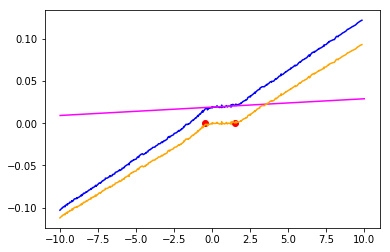

Sheet index = 1


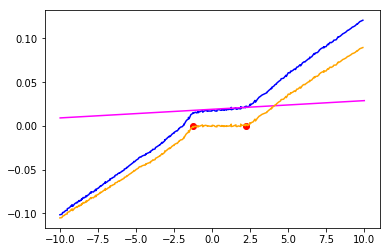

Sheet index = 2


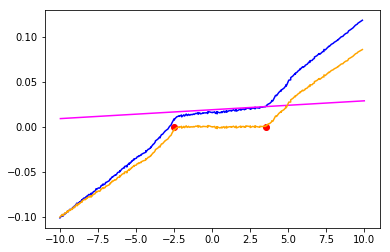

Sheet index = 3


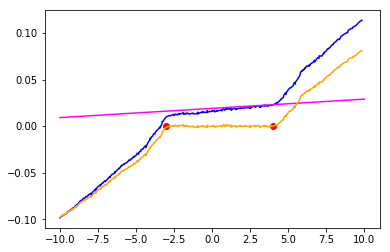

Sheet index = 4


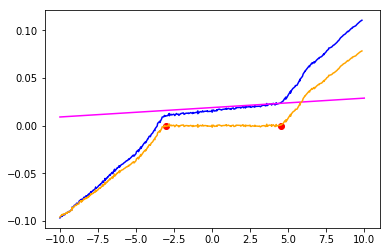

Sheet index = 5


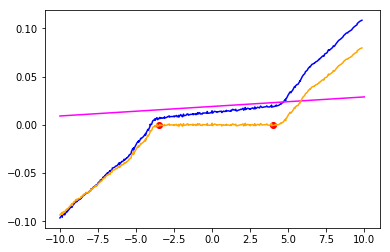

Sheet index = 6


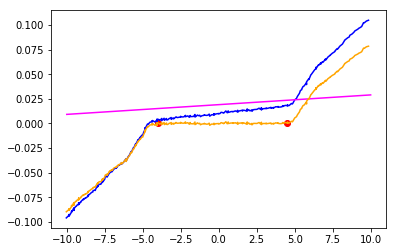

Sheet index = 7


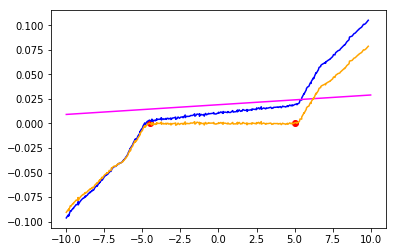

Sheet index = 8


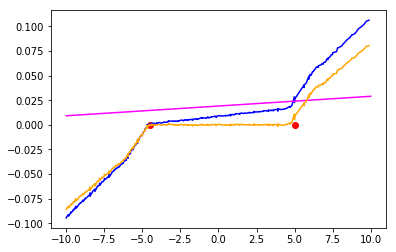

Sheet index = 9


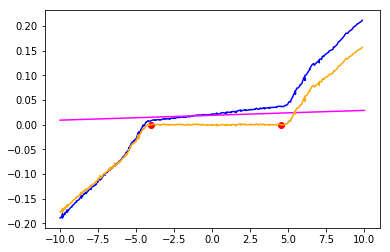

Sheet index = 10


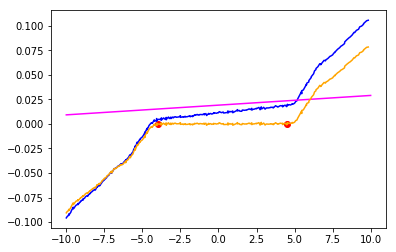

Sheet index = 11


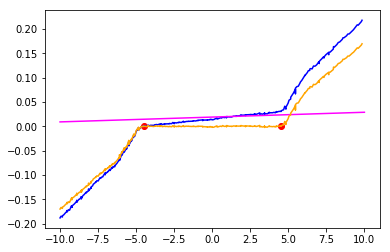

Sheet index = 12


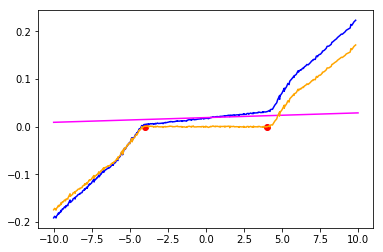

Sheet index = 13


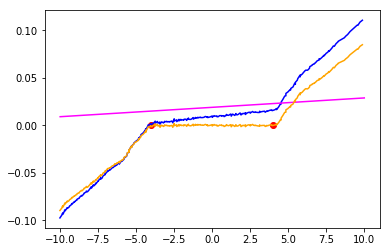

Sheet index = 14


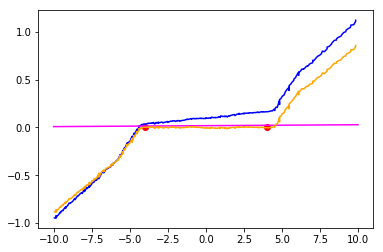

Sheet index = 15


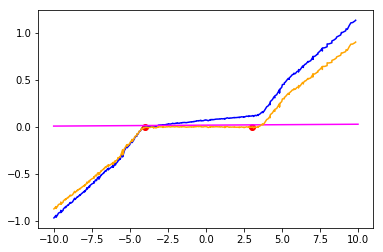

Sheet index = 16


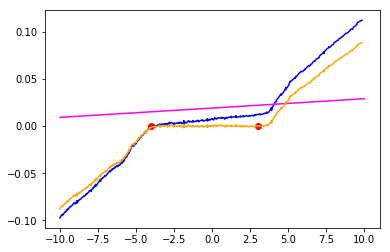

Sheet index = 17


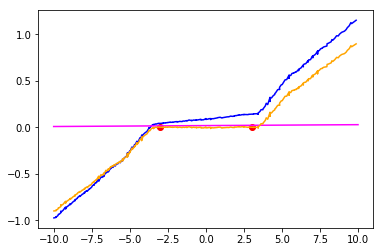

Sheet index = 18


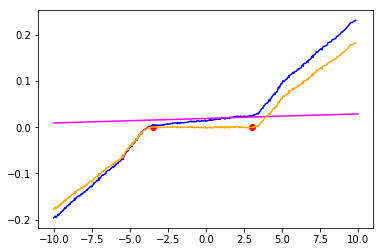

Sheet index = 19


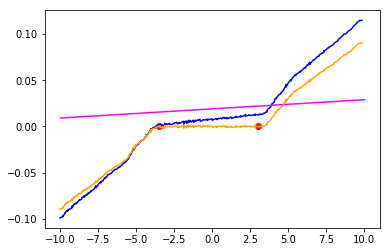

Sheet index = 20


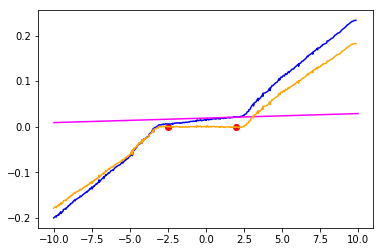

Sheet index = 21


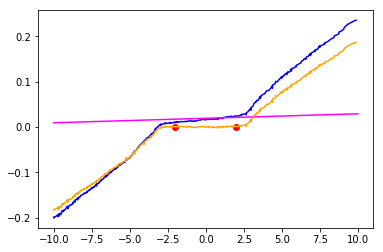

Sheet index = 22


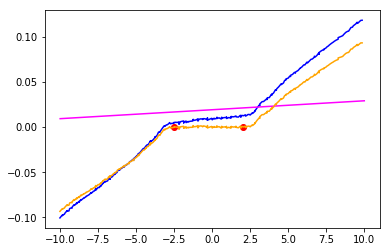

Sheet index = 23


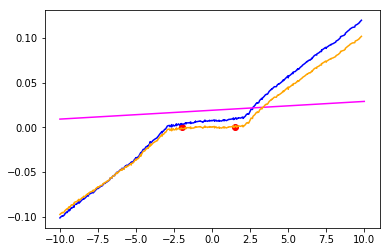

Sheet index = 24


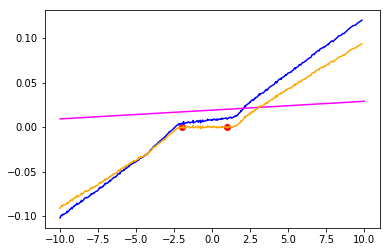

Sheet index = 25


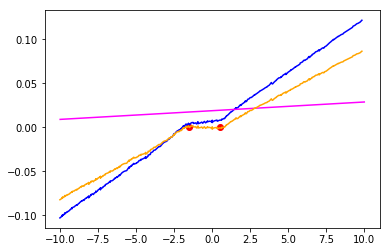

Sheet index = 26


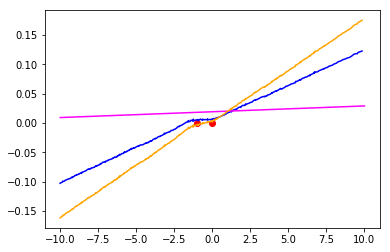

Sheet index = 27


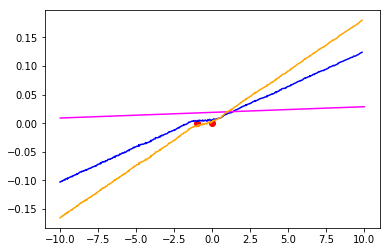

Sheet index = 28


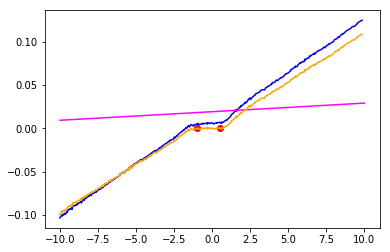

Sheet index = 29


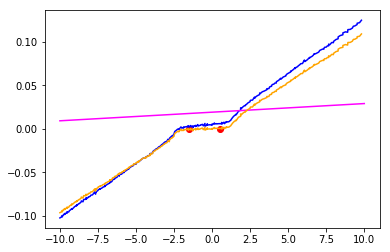

Sheet index = 30


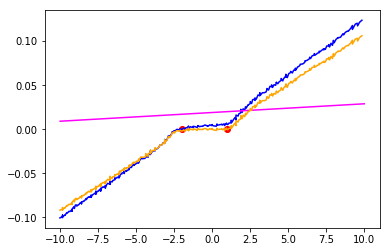

Sheet index = 31


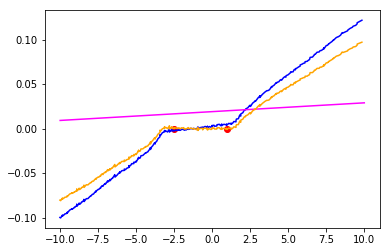

In [21]:
for sheet_idx in range(len(mod_no_linear_trend_list)):
    fig, ax = plt.subplots()
    print('Sheet index = {}'.format(sheet_idx))
    chan_1_no_lin, chan_2_no_lin = zip(*mod_no_linear_trend_list[sheet_idx][0])
    chan_1, chan_2 = zip(*mod_DataSheets[sheet_idx].combined_set)
    
    # Plot the original data
    ax.plot(chan_1, chan_2, color='blue')
    
    # Plot the linear fit to the superconducting region
    x = np.linspace(-10, 10, 300)
    m = mod_no_linear_trend_list[0][1]
    b = mod_no_linear_trend_list[0][2]
    ax.plot(x, m*x + b, color='magenta')
    
    # Plot the linear trend subtracted data
    ax.plot(chan_1_no_lin, chan_2_no_lin, color='orange')
    
    # Plot the kink locations
    ax.scatter(loc_array[sheet_idx, 1], 0, color='red')
    ax.scatter(loc_array[sheet_idx, 2], 0, color='red')
    
    # Show the plot
    plt.show()

Sheet index = 0


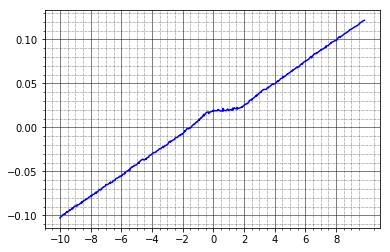

Sheet index = 1


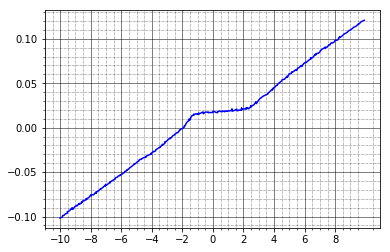

Sheet index = 2


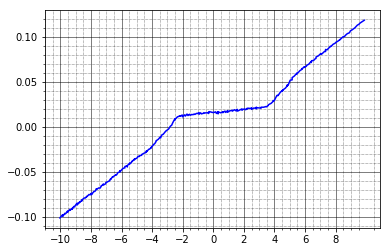

Sheet index = 3


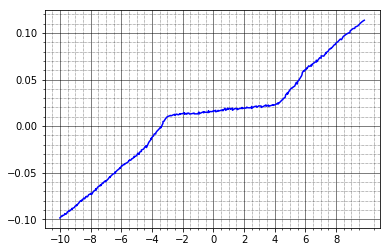

Sheet index = 4


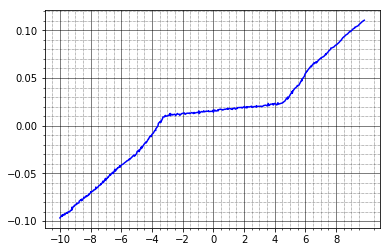

Sheet index = 5


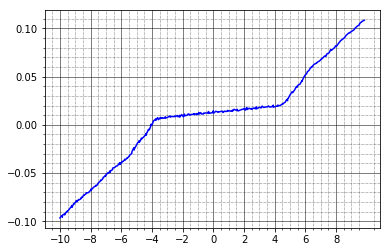

Sheet index = 6


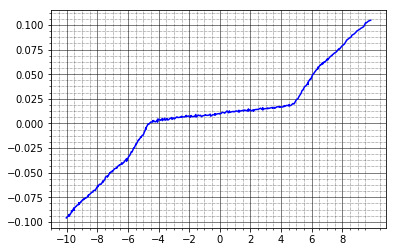

Sheet index = 7


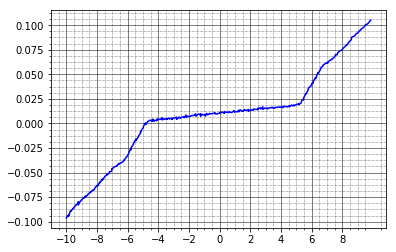

Sheet index = 8


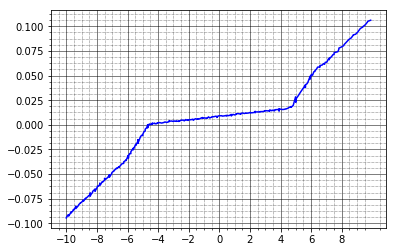

Sheet index = 9


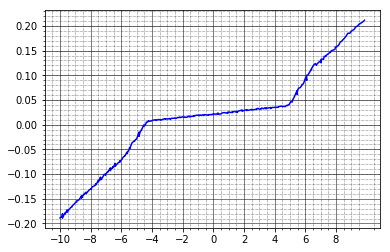

Sheet index = 10


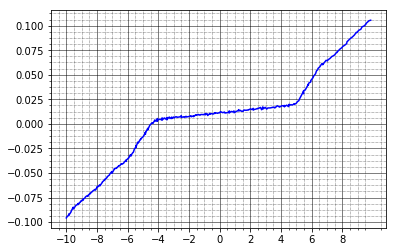

Sheet index = 11


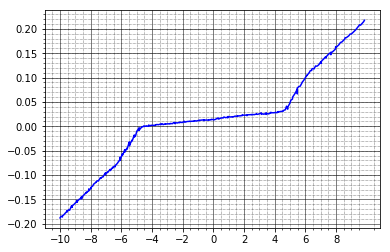

Sheet index = 12


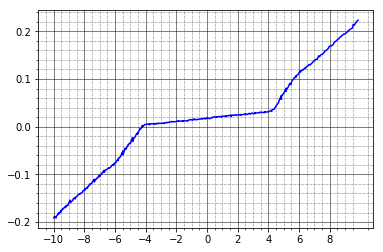

Sheet index = 13


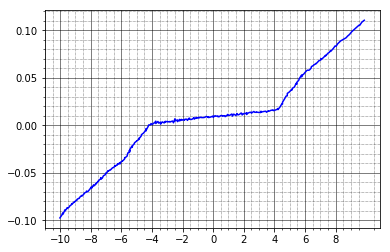

Sheet index = 14


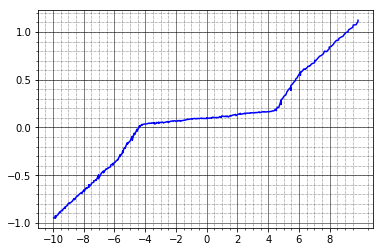

Sheet index = 15


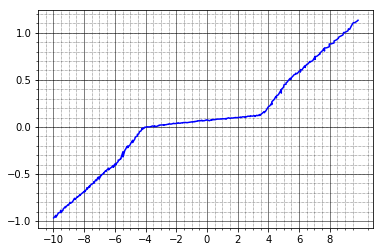

Sheet index = 16


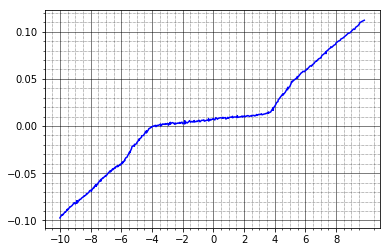

Sheet index = 17


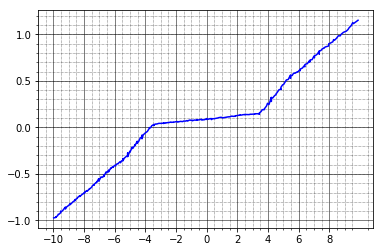

Sheet index = 18


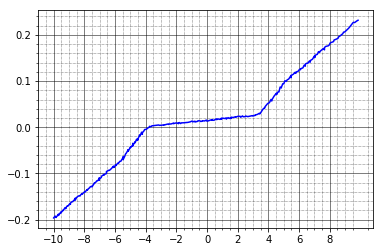

Sheet index = 19


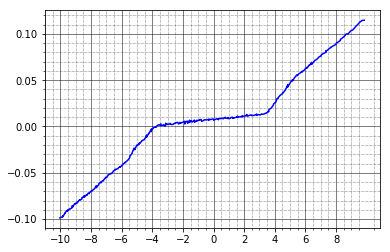

Sheet index = 20


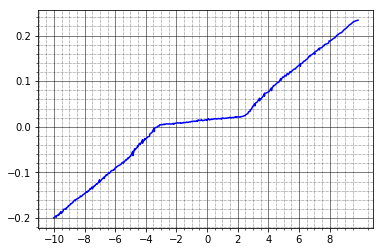

Sheet index = 21


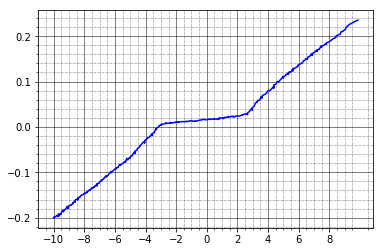

Sheet index = 22


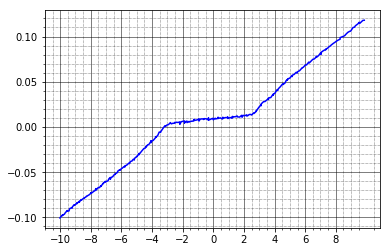

Sheet index = 23


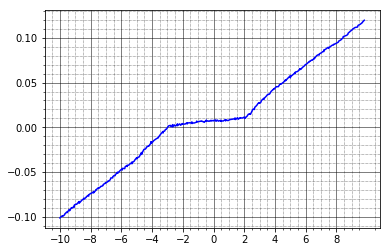

Sheet index = 24


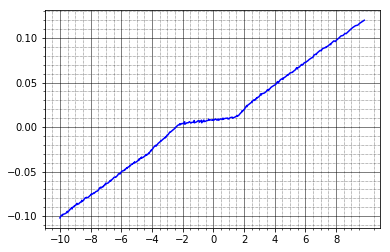

Sheet index = 25


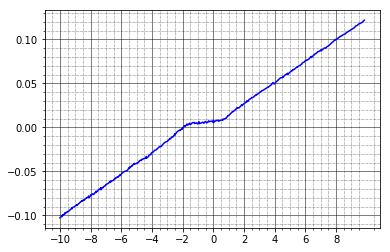

Sheet index = 26


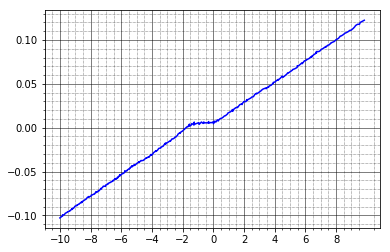

Sheet index = 27


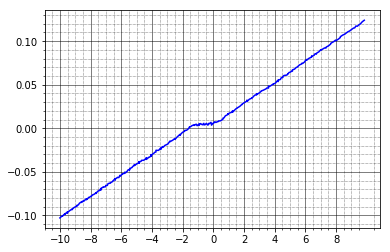

Sheet index = 28


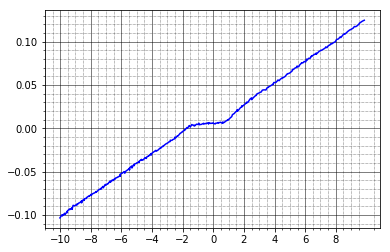

Sheet index = 29


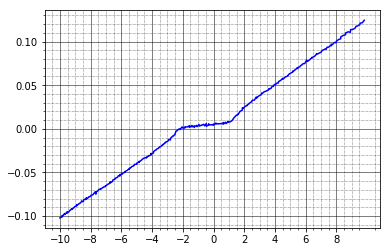

Sheet index = 30


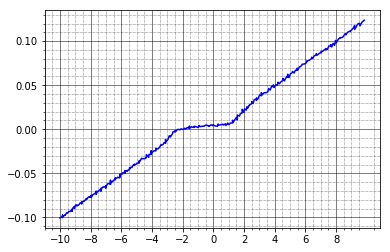

Sheet index = 31


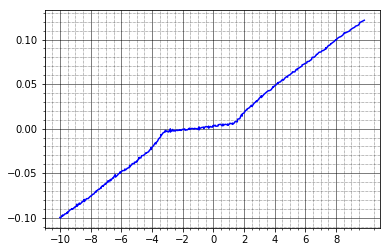

In [34]:
for sheet_idx in range(len(mod_no_linear_trend_list)):
    fig, ax = plt.subplots()
    print('Sheet index = {}'.format(sheet_idx))
    chan_1_no_lin, chan_2_no_lin = zip(*mod_no_linear_trend_list[sheet_idx][0])
    chan_1, chan_2 = zip(*mod_DataSheets[sheet_idx].combined_set)

    # Plot the original data
    ax.plot(chan_1, chan_2, color='blue')
    
    # Don't allow the axis to be on top of your data
    ax.set_axisbelow(True)
    
    ax.set_xticks(range(-10, 10, 2))

    # Turn on the minor TICKS, which are required for the minor GRID
    ax.minorticks_on()

    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

### Trying to fit curve for critical current

In [22]:
def heaviside(x1):
    return 0.5*(np.sign(x1) + 1)

In [23]:
def super_model(x, m_n, m_s, I_c_left, I_c_right):
    return m_n*(x-I_c_left)*(1 - heaviside(x - I_c_left))+m_n*(x-I_c_right)*heaviside(x - I_c_right) + m_s*x*(heaviside(x - I_c_left) - heaviside(x - I_c_right))

500
Sheet index = 0


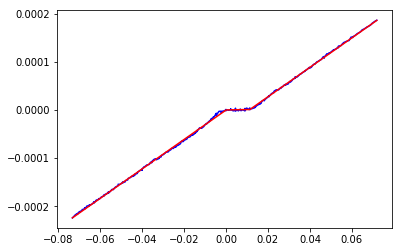

500
Sheet index = 1


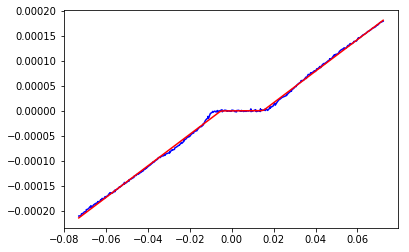

500
Sheet index = 2


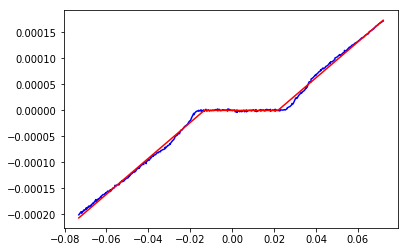

500
Sheet index = 3


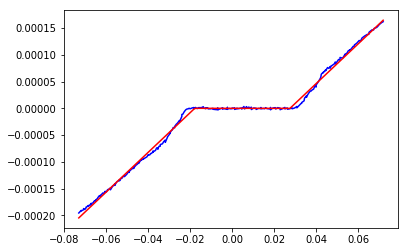

500
Sheet index = 4


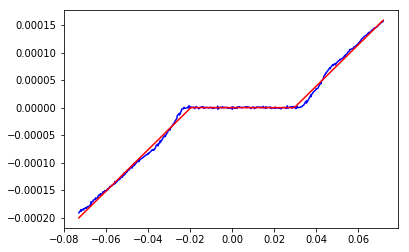

500
Sheet index = 5


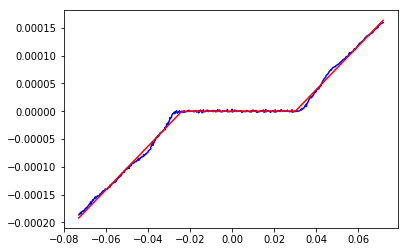

500
Sheet index = 6


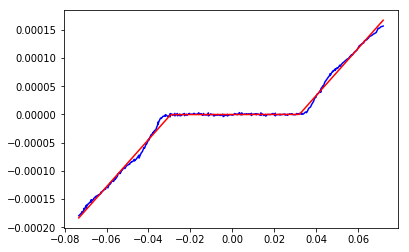

500
Sheet index = 7


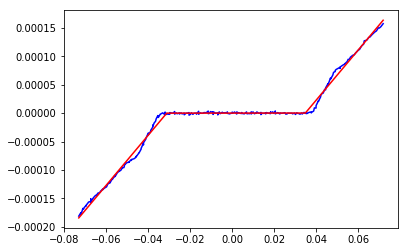

500
Sheet index = 8


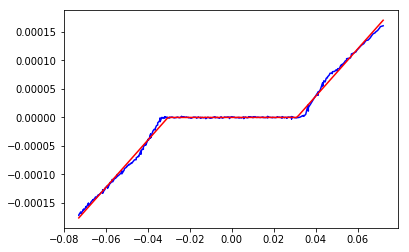

1000
Sheet index = 9


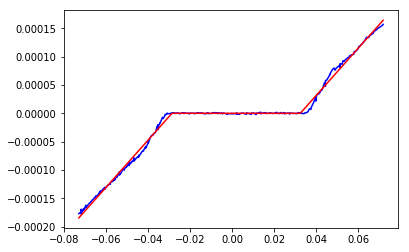

500
Sheet index = 10


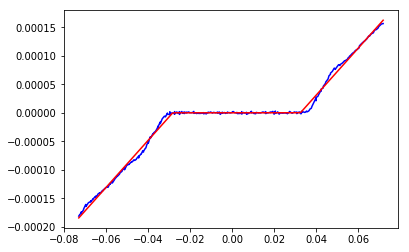

1000
Sheet index = 11


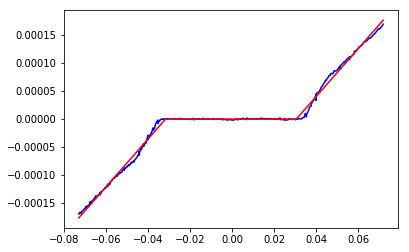

1000
Sheet index = 12


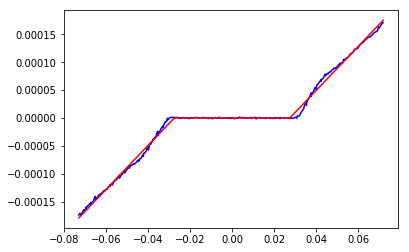

500
Sheet index = 13


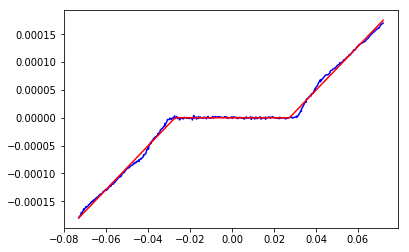

50000
Sheet index = 14


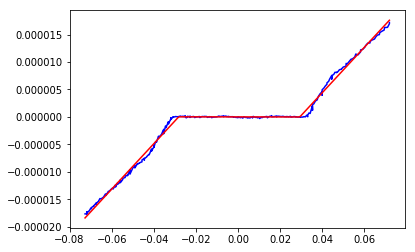

5000
Sheet index = 15


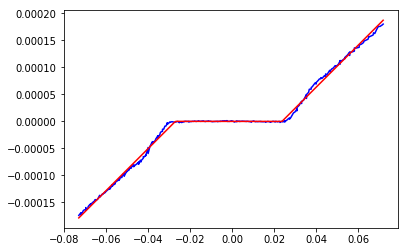

500
Sheet index = 16


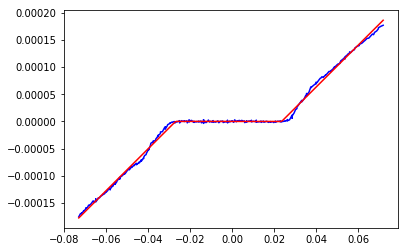

5000
Sheet index = 17


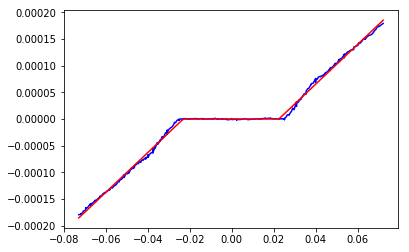

1000
Sheet index = 18


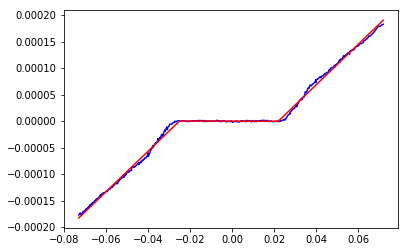

500
Sheet index = 19


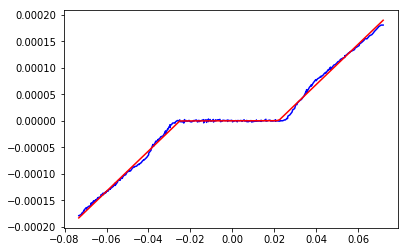

1000
Sheet index = 20


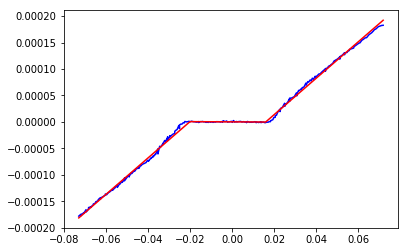

1000
Sheet index = 21


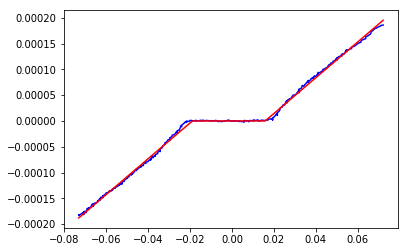

500
Sheet index = 22


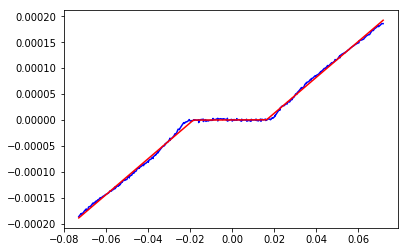

500
Sheet index = 23


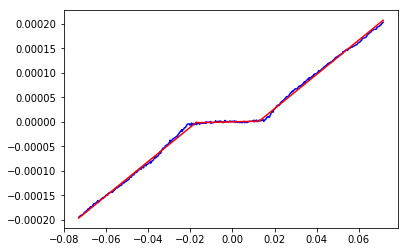

500
Sheet index = 24


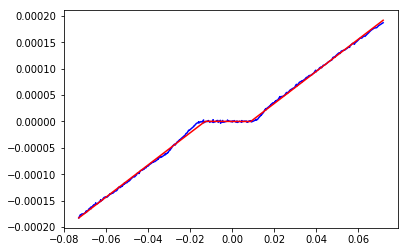

500
Sheet index = 25


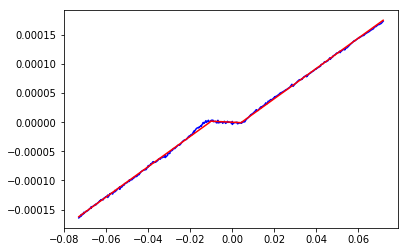

500
Sheet index = 26


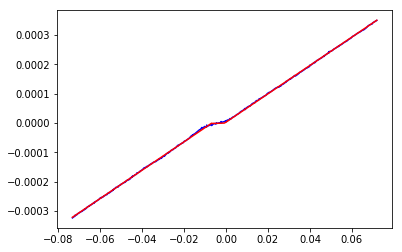

500
Sheet index = 27


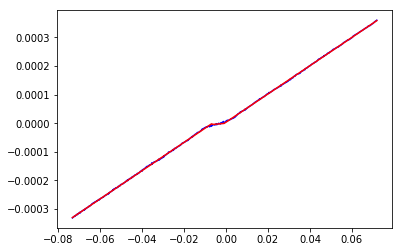

500
Sheet index = 28


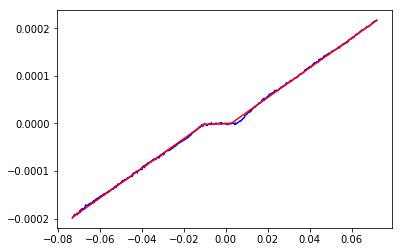

500
Sheet index = 29


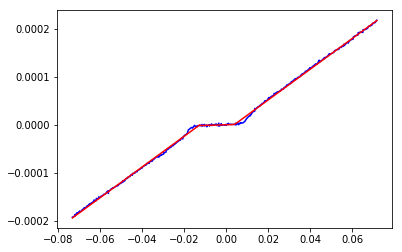

500
Sheet index = 30


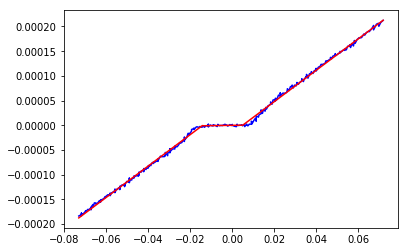

500
Sheet index = 31


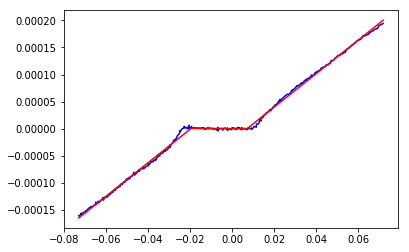

In [42]:
# Fits curves to IV plots (also converts data to correct units)
curve_fits = []
for i,sheet in enumerate(mod_DataSheets):
    
    gain = sheet.setup_params['srs gain']
    resistance = sheet.setup_params['resistance']
    
    print(gain)
    
    print("Sheet index = {}".format(i))
    chan_1, chan_2 = zip(*mod_no_linear_trend_list[i][0])
    
    chan_1 = np.asarray(chan_1)
    chan_2 = np.asarray(chan_2)
    
    # Convert the chan_1 voltage into current
    chan_1 = chan_1 / resistance
    
    # Scale the output signal down by the gain from the SRS
    chan_2 = chan_2 / gain
    
    loc_1 = loc_array[0, 1]
    loc_2 = loc_array[0, 2]
    
    popt, pcov = curve_fit(super_model, chan_1, chan_2, p0=[0.01, 0.005, (loc_1 + 0.5)/resistance, (loc_2 - 0.5)/resistance])
    
    y = super_model(chan_1, popt[0], popt[1], popt[2], popt[3])
    
    fig, ax = plt.subplots()
    
    ax.plot(chan_1, y, color='red', label='fit', zorder=2)
    ax.plot(chan_1, chan_2, color='blue', label='data', zorder=0)
    
    plt.show()
    
    y = np.asarray(y)
    chan_2 = np.asarray(chan_2)
    
    fit_tuple = (chan_1, chan_2, popt, pcov)
    curve_fits.append(fit_tuple)